In [1]:
! pip install pyro-ppl

In [2]:
import random
import string
import os
import itertools
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.distributions.utils import probs_to_logits
from utils import *

In [3]:
pcfg = {
  "name": "astronomers",
  "terminals": ["astronomers", "ears", "saw", "stars", "telescopes", "with"],
  "non_terminals": ["S", "NP", "VP", "PP", "P", "V"],
  "productions": {
    "S": [["NP", "VP"]],
    "NP": [["NP", "PP"], ["astronomers"], ["ears"], ["saw"], ["stars"], ["telescopes"]],
    "VP": [["V", "NP"], ["VP", "PP"]],
    "PP": [["P", "NP"]],
    "P": [["with"]],
    "V": [["saw"]]
  },
  "start_symbol": "S",
}
true_production_probs = {
    "S": [1.0],
    "NP": [0.4, 0.1, 0.18, 0.04, 0.18, 0.1],
    "VP": [0.7, 0.3],
    "PP": [1.0],
    "P": [1.0],
    "V": [1.0]
}
max_depth_parse_tree = 20
slient = True
terminate_symbol = "__"

In [4]:
prior_production_logits = {
    k: torch.randn((len(v),)) 
    for k, v in pcfg['productions'].items()
}
ground_truth_production_logits = {
    k: probs_to_logits(torch.tensor(true_production_probs[k]))
    for k, v in pcfg['productions'].items()
}
if not slient:
    print(prior_production_logits)
    print(ground_truth_production_logits)

In [5]:
def generate_sentences(production_logits):
    
    def sample_parse_tree(symbol = None, depth = 0, suffix = "root"):
        if symbol is None:
            symbol = pcfg['start_symbol']
        if symbol in pcfg['terminals']:
            return symbol
        elif depth > max_depth_parse_tree:
            return terminate_symbol
        else:
            if not slient:
                print("symbol=>", symbol, production_logits[symbol])
            distribution = dist.Categorical(logits=production_logits[symbol])
            production_index = distribution.sample().detach()
            production = pcfg['productions'][symbol][production_index]
            return [symbol] + \
                [sample_parse_tree(s, depth=depth + 1, suffix = f"{suffix}_d{depth}/{i}") for i, s in enumerate(production)]
    tree = sample_parse_tree()
    if not slient:
        print("tree =>", tree)
    sentence = get_leaves(tree, max_depth_parse_tree, terminate_symbol)
    # how do we state observations, levenshtein distance?
    # may also use factor on levenshtein distance between gen and obs sentences and observe with 0

    # pad and normal distribution but very low sigma
    gen_sentence = pad_sentence(sentence_to_one_hots(sentence, pcfg["terminals"]), len(sentence))
    return sentence, gen_sentence, tree
if not slient:
    print(generate_sentences(prior_production_logits))
    print(generate_sentences(ground_truth_production_logits))

In [6]:
import model as model
import guide_lstm_v4 as guide

In [7]:
if not slient:
    model.model(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [8]:
obs_embedder_gru = nn.GRU(
    input_size=6,
    hidden_size=100,
    num_layers=1
)

def wrapped_guide(start_symbol='S', terminals=["astronomers", "ears", "saw", "stars", "telescopes", "with"], 
                  max_depth_parse_tree=20, terminate_symbol='__', observations={'obs': 0}):
    #print("print(observations['obs'].shape)", observations['obs'].shape)
    pyro.module('obs_embedder_gru', obs_embedder_gru)
    embedded_obs, _ = obs_embedder_gru(observations['obs'].unsqueeze(1))
    return guide.model(start_symbol, terminals, max_depth_parse_tree, terminate_symbol, {'obs' : embedded_obs[-1][0]})
if not slient:
    wrapped_guide(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [9]:
import tqdm
import matplotlib.pyplot as plt

In [10]:
pyro.clear_param_store()
smoke_test = False
n_steps = 10 if smoke_test else 20000
interval = 1 if smoke_test else 50
num_inference_samples = 2 if smoke_test else 10
optimiser = optim.Adam({"lr": 0.0005})
csis = pyro.infer.CSIS(model.model, wrapped_guide, optimiser, num_inference_samples=num_inference_samples)
avg_l = 0
loss_trace = []
steps = []

In [11]:
def print_weights(name, model):
    print("@params in", name)
    for param in model.parameters():
        print(param)
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [12]:
def draw_from_model(n=1000, ground_truth=True):
    logits = production_logits if not ground_truth else ground_truth_production_logits
    sample_sentences = [generate_sentences(logits) for _ in range(n)]
    return sample_sentences
sample_sentences = draw_from_model(n=n_steps)
if not slient:
    sample_sentences[0]

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n1 = count_parameters(guide._nn_model_sample_parse_tree_production_index_lstm)
n2 = count_parameters(guide._nn_model_sample_parse_tree_production_index_VP)
n3 = count_parameters(guide._nn_model_sample_parse_tree_production_index_NP)
n4 = count_parameters(obs_embedder_gru)
print(n1, n2, n3, n4, "total:", n1+n2+n3+n4)


85600 15794 16134 32400 total: 149928


  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_lstm_v4.py:176: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_VP_params,
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_lstm_v4.py:163: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_NP_params,
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [2:00:36<00:00,  2.76it/s]


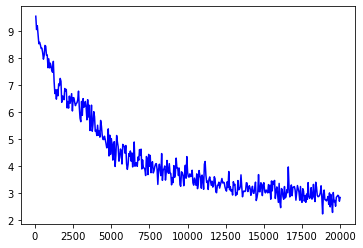

In [14]:
for step in tqdm.trange(n_steps):
    obs = sample_sentences[step]
    loss = csis.step(observations={"obs" : obs[1]})
    avg_l += loss
    if (step + 1) % interval == 0:
        steps.append(step)
        loss_trace.append(avg_l / interval)
        avg_l = 0

plt.plot(steps, loss_trace, "-b")
plt.show()

In [15]:
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [16]:
def drop_paddings(sentence_tensor):
    has_values = sentence_tensor.abs().sum(dim=-1).bool()
    return sentence_tensor[has_values]

In [17]:
def one_hot_sentence_to_list(sentence_tensor, terminals):
    sentence_np = sentence_tensor.cpu().detach().numpy()
    sentence_indices = np.argmax(sentence_np, axis=1)
    return [terminals[i] for i in sentence_indices]

In [18]:
def test(sentences, n=1):
    num_correct_n = 0
    num_correct_all = 0
    levenshtein_distances = {}
    for i in tqdm.trange(len(sentences)):
        obs = sentences[i]
        posterior = csis.run(observations={"obs" : obs[1]})
        marginal_ret = pyro.infer.EmpiricalMarginal(posterior)
        
        for i_sample in range(n):
            
            with torch.no_grad():
                _ret = marginal_ret()

            _ret = drop_paddings(_ret)
            num_correct_n += (torch.sum(obs[1]) == torch.sum(_ret))
            num_correct_all += torch.equal(obs[1], _ret)
            lev_dis = get_levenshtein_distance(one_hot_sentence_to_list(_ret, pcfg["terminals"]), 
                                               one_hot_sentence_to_list(obs[1], pcfg["terminals"]),
                                               pcfg["terminals"])
            if lev_dis in levenshtein_distances:
                levenshtein_distances[lev_dis] += 1
            else:
                levenshtein_distances[lev_dis] = 1
    
    avg_dis = 0  
    
    for k, v in levenshtein_distances.items():
        avg_dis += k * v

    return int(num_correct_n)  / len(sentences), int(num_correct_all) / len(sentences), levenshtein_distances, avg_dis / (len(sentences) * n)

example = ["astronomers", "saw", "stars", "with", "telescopes"]
example_sentence = sentence_to_one_hots(example, pcfg["terminals"])
print("example, n=1000", test([[None, example_sentence]], n=1000))
print("examples, 1000", test([[None, example_sentence]] * 1000))
print("train", test(sample_sentences[:1000]))
test_sentences = draw_from_model(n=1000)
print("test", test(test_sentences))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


example, n=1000 (1000.0, 1000.0, {0: 1000}, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:06<00:00,  5.36it/s]


examples, 1000 (1.0, 1.0, {0: 1000}, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:00<00:00,  2.38it/s]


train (0.753, 0.581, {0: 581, 6: 27, 5: 20, 11: 9, 12: 10, 4: 30, 9: 15, 21: 6, 8: 18, 1: 57, 3: 38, 2: 49, 7: 27, 18: 10, 15: 9, 17: 5, 14: 7, 31: 1, 16: 5, 38: 2, 10: 16, 26: 1, 24: 1, 13: 12, 27: 3, 19: 6, 23: 4, 36: 2, 39: 1, 30: 3, 32: 2, 44: 2, 35: 1, 25: 4, 22: 2, 45: 2, 34: 3, 33: 1, 20: 1, 41: 1, 37: 1, 28: 2, 65: 1, 29: 1, 43: 1}, 3.85)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:05<00:00,  2.35it/s]

test (0.733, 0.586, {0: 586, 6: 23, 2: 43, 7: 26, 1: 49, 11: 11, 15: 11, 8: 15, 27: 4, 24: 5, 12: 12, 13: 15, 3: 40, 23: 7, 19: 6, 4: 31, 16: 6, 25: 3, 31: 1, 5: 34, 18: 5, 14: 9, 17: 6, 9: 12, 10: 14, 20: 1, 26: 2, 54: 1, 28: 1, 29: 3, 80: 1, 32: 2, 48: 1, 42: 1, 21: 4, 43: 2, 37: 2, 40: 1, 33: 2, 39: 1, 46: 1}, 3.795)


In [19]:
test_sentences = draw_from_model(n=10000)
print("test", test(test_sentences))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:08:37<00:00,  2.43it/s]

test (0.7546, 0.5959, {0: 5959, 8: 173, 1: 591, 12: 107, 9: 158, 4: 280, 5: 258, 10: 136, 2: 464, 3: 372, 13: 94, 16: 74, 25: 26, 6: 220, 18: 46, 17: 69, 29: 20, 28: 19, 15: 79, 20: 42, 7: 242, 19: 54, 22: 35, 24: 26, 27: 19, 49: 1, 35: 9, 21: 30, 11: 118, 14: 82, 26: 16, 55: 3, 38: 10, 34: 8, 47: 1, 40: 7, 41: 9, 33: 13, 32: 5, 54: 1, 48: 5, 23: 30, 61: 2, 39: 9, 56: 2, 45: 3, 37: 8, 58: 3, 31: 9, 44: 6, 36: 5, 30: 9, 50: 4, 68: 1, 53: 2, 102: 1, 43: 5, 46: 3, 51: 4, 75: 2, 57: 3, 52: 2, 42: 3, 76: 1, 90: 1, 67: 1}, 3.5578)


In [20]:
example2 = ["stars", "saw"]
get_levenshtein_distance(example, example2, pcfg["terminals"])

4

In [21]:
print(loss_trace)

[9.539140541553497, 9.046831094622611, 9.190324754714966, 8.839571338891982, 8.522450342774391, 8.576589232683181, 8.481574242711067, 8.349293414354324, 8.360728414654732, 8.194576056003571, 7.951866629421711, 8.089380737841129, 8.458619116842748, 8.430997808873654, 8.104511315971614, 8.106293751895429, 7.635070837587119, 7.965358893722295, 7.630726447626948, 7.803700765147806, 7.693848019093275, 7.528258177042008, 7.468898741826415, 7.870956387817859, 7.132791579365731, 6.6811365308612585, 6.81133210670203, 6.474369406476617, 6.8270916292443875, 6.598019598182291, 7.037510978961364, 6.9747353220358494, 7.241035589762032, 7.1356323161348705, 6.3577003906294705, 6.589604676337912, 6.569489012835548, 6.453354134308174, 6.868472284320742, 6.7683881532913075, 6.833844980048016, 6.150282042953186, 6.388494618451222, 6.143390349266119, 6.58766213573981, 6.318898886884563, 6.510016562289093, 6.677858962088358, 6.037507508024573, 6.531963431215845, 6.521797057983931, 6.3547778321895745, 6.2349

In [22]:
print(min(loss_trace), loss_trace.index(min(loss_trace)))

2.23209909531317 376


In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n1 = count_parameters(guide._nn_model_sample_parse_tree_production_index_lstm)
n2 = count_parameters(guide._nn_model_sample_parse_tree_production_index_VP)
n3 = count_parameters(guide._nn_model_sample_parse_tree_production_index_NP)
n4 = count_parameters(obs_embedder_gru)
print(n1, n2, n3, n4, "total:", n1+n2+n3+n4)


85600 15794 16134 32400 total: 149928
